In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import glob
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import norm
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

## ADD LIDAR DATA
#### This script grabs slices from Tuolumne Basin by the 'x' and 'y' TUMs.
##### pix = variable that defines the number of pixels in each direction from a midpoint. 
##### pix_value * 3 is the distance for the box size. 

dana meadow
x direction length 150.0 [m]:
y direction length 150.0 [m]:
tuolumne meadow
x direction length 150.0 [m]:
y direction length 150.0 [m]:
slide canyon
x direction length 150.0 [m]:
y direction length 150.0 [m]:


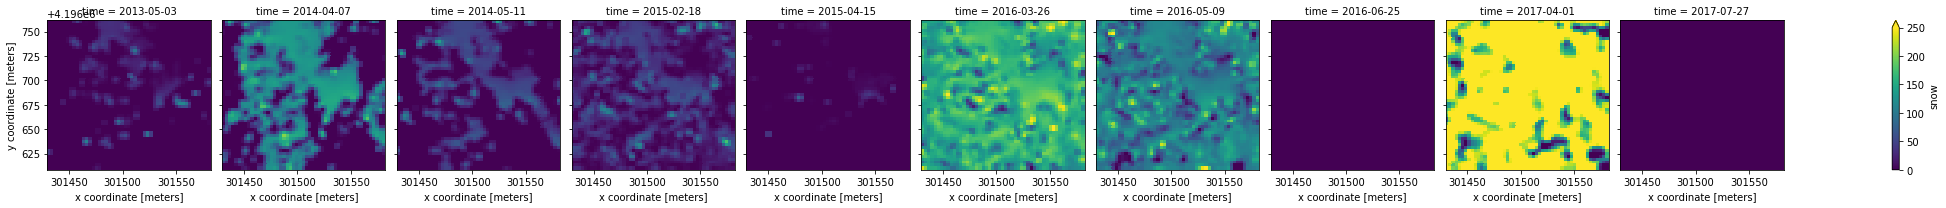

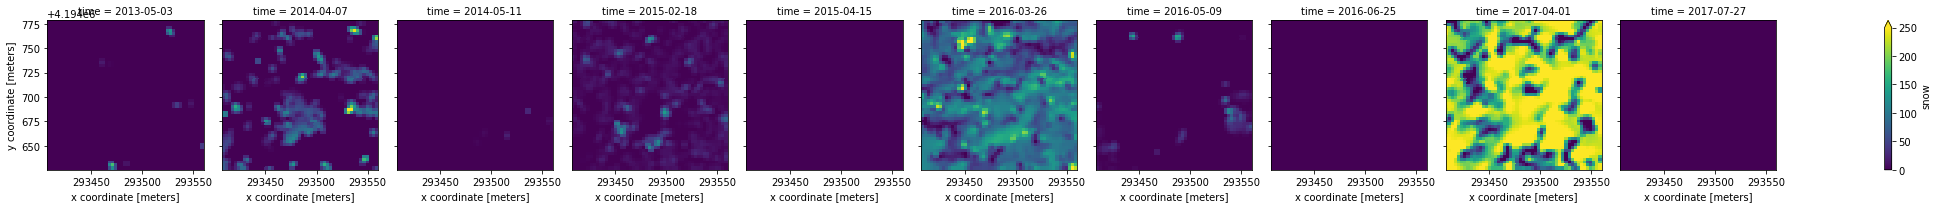

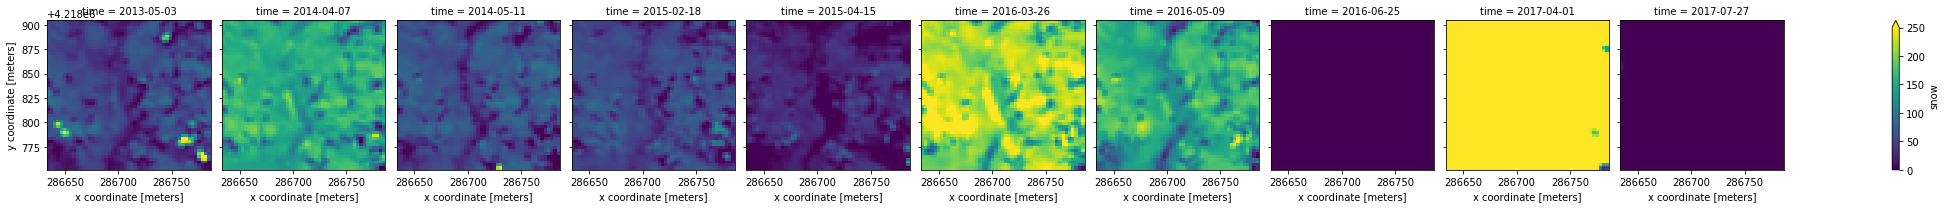

In [15]:
fname = '/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow.nc' #3m BSU
# fname = '/Users/megmason/research/sierra/data/compiled_SUPERsnow_20m.nc' #20m mac #CAREFUL THIS IS 20m DATA

#open data
ds = xr.open_dataset(fname, chunks={'time':1,'x':1000,'y':1000})
ds['snow'] = ds.snow / 10
ds.attrs['units'] = 'cm'
ds=ds.astype(np.int16, copy=False)
ds.close()

#station slices
pix = 75 #multipy by 2 to get x and y distance of box sz (cheatsheet: 15=30m, 75=150m, 501=1000m...yes 501)
dan = ds.sel(x=slice(301506.-pix, 301506.+pix), y=slice(4196685.+pix, 4196685.-pix)) #x=301506.26, y=4196685.89
tum = ds.sel(x=slice(293484.-pix, 293484.+pix), y=slice(4194702.+pix, 4194701.-pix)) #x=293484.72, y=4194701.07
sli = ds.sel(x=slice(286708.-pix, 286710.+pix), y=slice(4218828.+pix, 4218826.-pix)) #x=286708.13, y=42188826.62 #due to rounding, made x and y have 2 pix apart

# dan.isel(time=32).snow.plot()
d = dan.isel(time=slice(2,51,5)).snow.plot(x='x', y='y', col='time', vmax=250)
t = tum.isel(time=slice(2,51,5)).snow.plot(x='x', y='y', col='time', vmax=250)
s = sli.isel(time=slice(2,51,5)).snow.plot(x='x', y='y', col='time', vmax=250)

print('dana meadow')
print('x direction length {} [m]:'.format(dan.x.max().values - dan.x.min().values))
print('y direction length {} [m]:'.format(dan.y.max().values - dan.y.min().values))

print('tuolumne meadow')
print('x direction length {} [m]:'.format(tum.x.max().values - tum.x.min().values))
print('y direction length {} [m]:'.format(tum.y.max().values - tum.y.min().values))

print('slide canyon')
print('x direction length {} [m]:'.format(sli.x.max().values - sli.x.min().values))
print('y direction length {} [m]:'.format(sli.y.max().values - sli.y.min().values))

In [17]:
#grab box size for output filename
# pix=pix-1 #cuz pixels aren't perfect????
bx_sz = pix * 2

#save station boxes at netCDFs
dan.to_netcdf('/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_{}m_dan.nc'.format(bx_sz))
tum.to_netcdf('/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_{}m_tum.nc'.format(bx_sz))
sli.to_netcdf('/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_{}m_sli.nc'.format(bx_sz))

In [ ]:
#specific cordinates

#~~~~150 m boxes
# pix = 75 #multipy by 2 to get x and y distance of box sz
# dan = ds.sel(x=slice(301506.-pix, 301506.+pix), y=slice(4196685.+pix, 4196685.-pix)) #x=301506.26, y=4196685.89
# tum = ds.sel(x=slice(293484.-pix, 293484.+pix), y=slice(4194702.+pix, 4194701.-pix)) #x=293484.72, y=4194701.07
# sli = ds.sel(x=slice(286708.-pix, 286710.+pix), y=slice(4218828.+pix, 4218826.-pix)) #x=286708.13, y=42188826.62

## ADD TERRAIN DATA

In [ ]:
#make subset dem hillshade for plot below
terr = terrain.isel(x=slice(8400,9400), y=slice(3000,4000))
print(terr)
levels_50=np.linspace(1500,4000,50)
plt.imshow(terr.hillshade)
plt.contour(ds.dem, levels=levels_50, colors='dimgray', linewidths=.45, alpha=.7)
plt.show